In [1]:
import numpy as np
import tensorflow as tf
from copy import deepcopy

import import_ipynb
from QBert import qbert_model

import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_pkl(file_path) :
    
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        
    return df

def save_pkl(df, file_path) :
    
    with open(file_path, 'wb') as f:
        pickle.dump(df, f)

def create_padding_mask(x):
    init_shape = x.shape
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return np.array(mask).reshape(init_shape[0], 1,1, init_shape[1])

def ind_to_weight(masked_pos, seq_len) :
    return tf.reduce_sum(tf.one_hot(masked_pos, seq_len), axis = 0)
    

importing Jupyter notebook from QBert.ipynb


In [2]:
class BertModule(tf.keras.Model) :

    def __init__(self, vocab_size, max_seq_len, num_layers, dff, d_model, num_heads, dropout, name) :
        super(BertModule, self).__init__()
        self.Bert = qbert_model(vocab_size, max_seq_len, num_layers, dff, d_model, num_heads, dropout, name)
        self.dense_cls = tf.keras.layers.Dense(2, activation = 'softmax', use_bias = False)
        self.vocab_size = vocab_size
    
    def call(self, inputs) :
        
        x, mask, lm, nsp, weight = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4]
    
        bert_outputs = self.Bert([x, mask])

        y_pred = bert_outputs['sequence_output']

        decode_matrix = tf.linalg.pinv(self.Bert.layers[1].weights[0])

        pred_lm =  tf.math.softmax(tf.matmul(y_pred, decode_matrix))
        pred_cls = self.dense_cls(y_pred[:, 0])

        true_y_lm = tf.cast(tf.one_hot(tf.cast(lm, dtype = tf.int32), depth = self.vocab_size), dtype = tf.float32)

        lm_losses = (tf.reduce_sum(true_y_lm * -tf.math.log(pred_lm), axis = 2))
        lm_losses = tf.reduce_mean(lm_losses * weight, axis = 1)
        
        nsp = tf.cast(nsp, dtype = tf.float32)
        cls_losses = tf.reduce_mean(tf.reduce_sum(nsp * -tf.math.log(pred_cls), axis = 1))

        total_loss = lm_losses + cls_losses

        return total_loss
    
    def get_pretrained_result(self, inputs) :
        
        x, mask = inputs[0], inputs[1]
    
        bert_outputs = self.Bert([x, mask])

        y_pred = bert_outputs['sequence_output']

        decode_matrix = tf.linalg.pinv(self.Bert.layers[1].weights[0])

        pred_lm =  tf.math.softmax(tf.matmul(y_pred, decode_matrix))
        pred_cls = self.dense_cls(y_pred[:, 0])
        
        return pred_lm, pred_cls

In [3]:
def get_BertModule(vocab_size, max_seq_len, num_layers, dff, d_model, num_heads, dropout, name) :
    
    x = tf.keras.Input(shape = (None, ), name = 'MASKED_X_INPUT')
    mask = tf.keras.Input(shape = (1, 1, None), name = 'MASKING_INPUT')
    lm = tf.keras.Input(shape = (None, ), name = 'WORD_LABEING_INPUT')
    nsp = tf.keras.Input(shape = (None, ), name = 'NEXT_SENTENCE_PREDICTION_INPUT')
    weight = tf.keras.Input(shape = (None, ), name = 'MASKING_WEIGHT')
    
    
    Bert = qbert_model(vocab_size, max_seq_len, num_layers, dff, d_model, num_heads, dropout, name)
    dense_cls = tf.keras.layers.Dense(2, activation = 'softmax', use_bias = False)

    bert_outputs = Bert([x, mask])

    y_pred = bert_outputs['sequence_output']

    decode_matrix = tf.linalg.pinv(Bert.layers[1].weights[0])

    pred_lm =  tf.math.softmax(tf.matmul(y_pred, decode_matrix))
    pred_cls = dense_cls(y_pred[:, 0])

    true_y_lm = tf.cast(tf.one_hot(tf.cast(lm, dtype = tf.int32), depth = vocab_size), dtype = tf.float32)

    lm_losses = (tf.reduce_sum(true_y_lm * -tf.math.log(pred_lm), axis = 2))
    lm_losses = tf.reduce_mean(lm_losses * weight, axis = 1)
    
    nsp = tf.cast(nsp, dtype = tf.float32)
    
    cls_losses = tf.reduce_mean(tf.reduce_sum(nsp * -tf.math.log(pred_cls), axis = 1))
    
    total_loss = lm_losses + cls_losses
    
    return tf.keras.Model(inputs = [x, mask, lm, nsp, weight], outputs = total_loss)

In [4]:
# train = load_pkl('./dt/train_set_under_255.pkl')
train = load_pkl('./dt/train_set-maksed-position-sample-10000.pkl')

In [5]:
train = list(filter(lambda x: len(x['x']) <= 130, train))

In [6]:
vocab_size = 32000
max_seq_len = 130
num_layers = 3
dff = 256
d_model = 100
num_heads = 5
dropout = .1
name = 'qbert_210603'

In [7]:
batch_size = 5

x = pad_sequences([ x['x'] for x in train ], max_seq_len, padding = 'post')
y = pad_sequences([ x['label'] for x in train ] , max_seq_len, padding = 'post')
nsp = np.asarray([ x['NSP'] for x in train ])

masked_lm_weight = np.array([ ind_to_weight(x['masked_position'], max_seq_len) for x in train])

mask = create_padding_mask(x)

In [8]:
epochs = 1
lr = 1e-3
batch_size = 5

optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999)

In [9]:
pretrainBert = BertModule(vocab_size, max_seq_len, num_layers, dff, d_model, num_heads, dropout, name)

In [10]:
pretrainBert([x[0:2], mask[0:2], y[0:2], nsp[0:2], masked_lm_weight[0:2]])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9267648 , 0.76721823], dtype=float32)>

In [11]:
pretrainBert.compile(optimizer=optimizer, loss ='mse')

In [12]:
false_y = np.array([ 0 for _ in range(len(x))])

In [ ]:
hist = pretrainBert.fit(batch_size = batch_size, epochs = epochs
                        , x = [x, mask, y, nsp, masked_lm_weight[:]], y = false_y)

C:\Users\LGCNS\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 150/1982 [=>............................] - ETA: 32:38 - loss: 2.0790

In [133]:
today = '210603'

pretrainBert.save('./model/BertPretrained-{}-{}-{}-{}-{}.pt'.format(today, max_seq_len, num_layers, d_model, num_heads))

INFO:tensorflow:Assets written to: ./model/BertPretrained-210603-130-3-100-5.pt\assets


## 결과 확인

In [134]:
sample_train_set = train[np.random.randint(0, len(train))]

In [25]:
test_set = load_pkl('./dt/train_set_under_255.pkl')[np.random.randint(10000, 1000000)]

In [135]:
from transformers import BertTokenizerFast

tokenizer_for_load = BertTokenizerFast.from_pretrained('./model/BertTokenizer-6000-32000-vocab.txt'
                                                   , strip_accents=False
                                                   , lowercase=False)

Calling BertTokenizerFast.from_pretrained() with the path to a single file or url is deprecated


In [146]:
train_statement = ' '.join(tokenizer_for_load.convert_ids_to_tokens(sample_train_set['x']))
train_statement

'[CLS] [MASK] 속 ##성이 유지 [MASK] 물질의 가장 정밀 ##한 부분은 미 ##립 [MASK] 수준에 있다고 논 ##평 ##했다 . [SEP] 그는 또한 공기 펌 ##프로 수 많은 조사를 수행 ##했으며 , 공기 ##가 펌 184 퍼져 나 ##감에 따라 수은 ##이 떨어지는 것으로 나타났다 . [SEP]'

In [147]:
train_statement = ' '.join(tokenizer_for_load.convert_ids_to_tokens(sample_train_set['label']))
train_statement

'[CLS] 그는 속 ##성이 유지 ##되는 물질의 가장 정밀 ##한 부분은 미 ##립 ##자의 수준에 있다고 논 ##평 ##했다 . [SEP] 그는 또한 공기 펌 ##프로 수 많은 조사를 수행 ##했으며 , 공기 ##가 펌 ##프로 퍼져 나 ##감에 따라 수은 ##이 떨어지는 것으로 나타났다 . [SEP]'

In [162]:
sample_train_set = train[np.random.randint(0, len(train))]

train_x = tf.reshape(sample_train_set['x'], (1, -1))
train_x = pad_sequences(train_x, max_seq_len, padding = 'post')
mask = create_padding_mask(train_x)

In [163]:
lm, nls = pretrainBert.get_pretrained_result([train_x, mask, "", "", ""])

In [175]:
tokenizer_for_load.convert_tokens_to_ids("그는")

8565

In [181]:
lm[0][0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=2.7333563e-05>

In [182]:
lm[0][0][15]

<tf.Tensor: shape=(), dtype=float32, numpy=0.019898778>

In [183]:
lm[0][0][8565]

<tf.Tensor: shape=(), dtype=float32, numpy=2.9875746e-05>

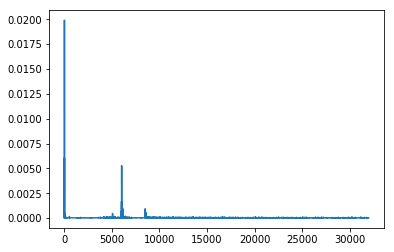

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lm[0][0])
plt.show()

In [164]:
tokenizer_for_load.convert_ids_to_tokens([15])

[',']

In [165]:
tf.argmax(lm, axis = 2)

<tf.Tensor: shape=(1, 130), dtype=int64, numpy=
array([[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15]], dtype=int64)>

In [166]:
nls

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.45470825, 0.5452918 ]], dtype=float32)>

In [184]:
pretrainBert.Bert.layers[1].weights[0]

<tf.Variable 'embedding_19/embeddings:0' shape=(32000, 100) dtype=float32, numpy=
array([[ 0.00675264,  0.02614969,  0.04783888, ...,  0.00074808,
         0.0081974 ,  0.02426926],
       [ 0.02625655,  0.00214106,  0.02599093, ..., -0.0249519 ,
        -0.02679936,  0.01629817],
       [ 0.00712447, -0.02990005,  0.02621973, ..., -0.00580653,
        -0.00704775,  0.00537025],
       ...,
       [-0.0472474 ,  0.00386853, -0.00768339, ...,  0.02705099,
        -0.03506238,  0.0258582 ],
       [-0.00262028,  0.02314945,  0.00940512, ...,  0.02038808,
         0.02099202, -0.02432241],
       [ 0.02712569, -0.00255732, -0.04550922, ..., -0.00697222,
        -0.04350788,  0.0189664 ]], dtype=float32)>